# NVIDIA AI Playground Embedding Models

>[NVIDIA AI Playground](https://www.nvidia.com/en-us/research/ai-playground/) gives users easy access to hosted endpoints for generative AI models like Llama-2, SteerLM, Mistral, etc. Using the API, you can query NVCR (NVIDIA Container Registry) function endpoints and get quick results from a DGX-hosted cloud compute environment. All models are source-accessible and can be deployed on your own compute cluster.

This example goes over how to use LangChain to interact with supported the NVOLVE question-answer embedding model [(NGC AI Playground entry in NGC)](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/ai-foundation/models/nvolve-29k)

## Setup

**To get started:**
1. Create a free account with the [NVIDIA GPU Cloud](https://catalog.ngc.nvidia.com/) service, which hosts AI solution catalogs, containers, models, etc.
2. Navigate to `Catalog > AI Foundation Models > (Model with API endpoint)`.
3. Select the `API` option and click `Generate Key`.
4. Save the generated key as `NVAPI_KEY`. From there, you should have access to the endpoints.

In [1]:
import getpass
import os

## API Key can be found by going to NVIDIA NGC -> AI Playground -> (some model) -> Get API Code or similar.
## 10K free queries to any endpoint (which is a lot actually).

# del os.environ['NVAPI_KEY']  ## delete key and reset
if os.environ.get("NVAPI_KEY", "").startswith("nvapi-"):
    print("Valid NVAPI_KEY already in environment. Delete to reset")
else:
    nvapi_key = getpass.getpass("NVAPI Key (starts with nvapi-): ")
    assert nvapi_key.startswith("nvapi-"), f"{nvapi_key[:5]}... is not a valid key"
    os.environ["NVAPI_KEY"] = nvapi_key

## Underlying Requests API

A selection of useful models are hosted in a DGX-powered service known as [NVIDIA GPU Cloud (NGC)](https://catalog.ngc.nvidia.com/). In this service, containers with exposed model endpoints are deployed and listed on the NVIDIA Container Registry service (NVCR). These systems are accessible via simple HTTP requests and can be utilized by a variety of systems.

The `NVCRModel` class implements the basic interfaces to communicate with NVCR, limiting the utility functions to those relevant for AI Playground. For example, the following list is populated by querying the function list endpoint with a key-loaded GET request:

In [2]:
from langchain.llms import NVAIPlayLLM

NVAIPlayLLM().available_models

['playground_llama2_code_34b',
 'playground_llama2_code_13b',
 'playground_fuyu_8b',
 'playground_nvolveqa_40k',
 'playground_gpt_steerlm_8b',
 'playground_gpt_qa_8b',
 'playground_sdxl',
 'playground_llama2_70b',
 'playground_clip',
 'playground_llama2_13b',
 'playground_neva_22b',
 'playground_mistral',
 'playground_llama2_steerlm_70b']

We should be able to see an embedding model among that list which can be used in conjunction with an LLM for effective RAG solutions. We can interface with this model pretty easily with the help of the `NVAIEmbeddings` model.

In [3]:
from langchain.embeddings import NVAIPlayEmbeddings

embedder = NVAIPlayEmbeddings()
# embedder = NVAIPlayEmbeddings(model="nvolve")  ## Possible option

This model is a fine-tuned E5-large model which supports the expected `Embeddings`` methods including:
- `embed_query`: Generate query embedding for a query sample.
- `embed_documents`: Generate passage embeddings for a list of documents which you would like to search over.
- `aembed_queries`/`embed_documents`: Asynchronous versions of the above.

Additionally, it also implements several convenience methods:
- `aembed_batch_query`/`aembed_batch_documents`: Calls the above async methods such that each entry of the input list is generated asynchronously.

### **Similarity/Speed Test**

The following is a quick test of the methods in terms of usage, format, and speed for the use case of embedding the following data points:

**Queries:**
- What's the weather like in Komchatka?
- What kinds of food is Italy known for?
- What's my name? I bet you don't remember...
- What's the point of life anyways?
- The point of life is to have fun :D

**Documents:**
- Komchatka's weather is cold, with long, severe winters.
- Italy is famous for pasta, pizza, gelato, and espresso.
- I can't recall personal names, only provide information.
- Life's purpose varies, often seen as personal fulfillment.
- Enjoying life's moments is indeed a wonderful approach.

### Query Embedding

In [4]:
import time

print("Single Query Embedding: ")
s = time.perf_counter()
q_embedding = embedder.embed_query("What's the weather like in Komchatka?")
elapsed = time.perf_counter() - s
print("\033[1m" + f"Executed in {elapsed:0.2f} seconds." + "\033[0m")
print("Shape:", (len(q_embedding),))

print("\nBatch Query Embedding: ")
s = time.perf_counter()
q_embeddings = [
    embedder.embed_query("What's the weather like in Komchatka?"),
    embedder.embed_query("What kinds of food is Italy known for?"),
    embedder.embed_query("What's my name? I bet you don't remember..."),
    embedder.embed_query("What's the point of life anyways?"),
    embedder.embed_query("The point of life is to have fun :D"),
]
elapsed = time.perf_counter() - s
print("\033[1m" + f"Executed in {elapsed:0.2f} seconds." + "\033[0m")
print("Shape:", (len(q_embeddings), len(q_embeddings[0])))

print("\nAsync Batch Query Embedding: ")
s = time.perf_counter()
# queries = [
#     embedder.aembed_query("What's the weather like in Komchatka?"),
#     embedder.aembed_query("What kinds of food is Italy known for?"),
#     embedder.aembed_query("What's my name? I bet you don't remember..."),
#     embedder.aembed_query("What's the point of life anyways?"),
#     embedder.aembed_query("The point of life is to have fun :D"),
# ]
# q_embeddings = await asyncio.gather(*queries)
q_embeddings = await embedder.aembed_batch_queries(
    [
        "What's the weather like in Komchatka?",
        "What kinds of food is Italy known for?",
        "What's my name? I bet you don't remember...",
        "What's the point of life anyways?",
        "The point of life is to have fun :D",
    ]
)
elapsed = time.perf_counter() - s
print("\033[1m" + f"Executed in {elapsed:0.2f} seconds." + "\033[0m")
print("Shape:", (len(q_embeddings), len(q_embeddings[0])))

Single Query Embedding: 
Executed in 0.71 seconds.
Shape: (1024,)

Batch Query Embedding: 
Executed in 2.97 seconds.
Shape: (5, 1024)

Async Batch Query Embedding: 
Executed in 0.63 seconds.
Shape: (5, 1024)


### Document Embedding

In [5]:
import time

print("Single Document Embedding: ")
s = time.perf_counter()
d_embeddings = embedder.embed_documents(
    [
        "Komchatka's weather is cold, with long, severe winters.",
    ]
)
elapsed = time.perf_counter() - s
print("\033[1m" + f"Executed in {elapsed:0.2f} seconds." + "\033[0m")
print("Shape:", (len(q_embedding),))

print("\nBatch Document Embedding: ")
s = time.perf_counter()
d_embeddings = embedder.embed_documents(
    [
        "Komchatka's weather is cold, with long, severe winters.",
        "Italy is famous for pasta, pizza, gelato, and espresso.",
        "I can't recall personal names, only provide information.",
        "Life's purpose varies, often seen as personal fulfillment.",
        "Enjoying life's moments is indeed a wonderful approach.",
    ]
)
elapsed = time.perf_counter() - s
print("\033[1m" + f"Executed in {elapsed:0.2f} seconds." + "\033[0m")
print("Shape:", (len(q_embeddings), len(q_embeddings[0])))

print("\nAsync Batch Document Embedding: ")
s = time.perf_counter()
d_embeddings = await embedder.aembed_batch_documents(
    [
        "Komchatka's weather is cold, with long, severe winters.",
        "Italy is famous for pasta, pizza, gelato, and espresso.",
        "I can't recall personal names, only provide information.",
        "Life's purpose varies, often seen as personal fulfillment.",
        "Enjoying life's moments is indeed a wonderful approach.",
    ]
)
elapsed = time.perf_counter() - s
print("\033[1m" + f"Executed in {elapsed:0.2f} seconds." + "\033[0m")
print("Shape:", (len(q_embeddings), len(q_embeddings[0])))

Single Document Embedding: 
Executed in 0.70 seconds.
Shape: (1024,)

Batch Document Embedding: 
Executed in 2.97 seconds.
Shape: (5, 1024)

Async Batch Document Embedding: 
Executed in 0.66 seconds.
Shape: (5, 1024)


Now that we've generated out embeddings, we can do a simple similarity check on the results to see which documents would have triggered as reasonable answers in a retrieval task:

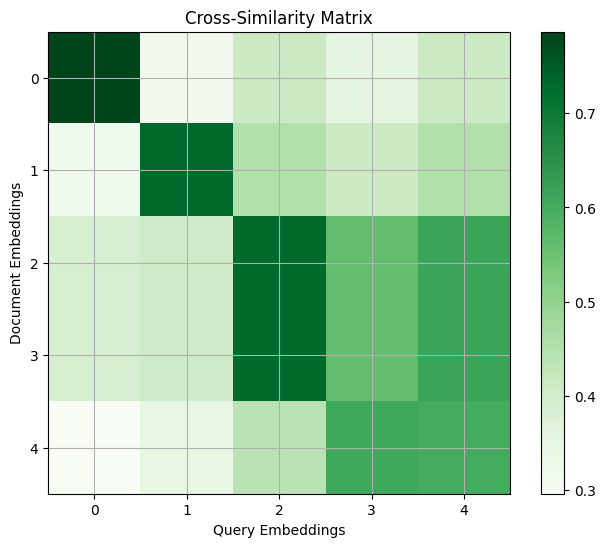

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Assuming embeddings1 and embeddings2 are your two sets of vectors
# Compute the similarity matrix between embeddings1 and embeddings2
cross_similarity_matrix = cosine_similarity(
    np.array(q_embeddings),
    np.array(d_embeddings),
)

# Plotting the cross-similarity matrix
plt.figure(figsize=(8, 6))
plt.imshow(cross_similarity_matrix, cmap="Greens", interpolation="nearest")
plt.colorbar()
plt.title("Cross-Similarity Matrix")
plt.xlabel("Query Embeddings")
plt.ylabel("Document Embeddings")
plt.grid(True)
plt.show()

As a reminder, the queries and documents sent to our system were:

**Queries:**
- What's the weather like in Komchatka?
- What kinds of food is Italy known for?
- What's my name? I bet you don't remember...
- What's the point of life anyways?
- The point of life is to have fun :D

**Documents:**
- Komchatka's weather is cold, with long, severe winters.
- Italy is famous for pasta, pizza, gelato, and espresso.
- I can't recall personal names, only provide information.
- Life's purpose varies, often seen as personal fulfillment.
- Enjoying life's moments is indeed a wonderful approach.

## RAG Retrieval:

The following is a repurposing of the initial example of the [LangChain Expression Language Retrieval Cookbook entry](
https://python.langchain.com/docs/expression_language/cookbook/retrieval), but executed with NVIDIA AI Playground's [Mistral 7B Instruct](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/ai-foundation/models/mistral-7b-instruct) and [NVOLVE Retrieval QA Embedding](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/ai-foundation/models/nvolve-29k) models. The subsequent examples in the cookbook also run as expected, and we encourage you to explore with these options.

**TIP:** We would recommend using Mistral for internal reasoning (i.e. instruction following for data extraction, tool selection, etc.) and Llama-Chat for a single final "wrap-up by making a simple response that works for this user based on the history and context" response.

In [7]:
!pip install langchain faiss-cpu tiktoken -q

from operator import itemgetter

from langchain.chat_models.nv_aiplay import GeneralChat, InstructChat
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough
from langchain.vectorstores import FAISS

In [8]:
vectorstore = FAISS.from_texts(
    ["harrison worked at kensho"],
    embedding=NVAIPlayEmbeddings(),
)
retriever = vectorstore.as_retriever()

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# model = GeneralChat()
model = InstructChat()

chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

chain.invoke("where did harrison work?")

'Based on the provided document and its page content, Harrison worked at Kensho.'

In [9]:
template = """Answer the question based only on the following context:
{context}

Question: {question}

Answer in the following language: {language}
"""
prompt = ChatPromptTemplate.from_template(template)

chain = (
    {
        "context": itemgetter("question") | retriever,
        "question": itemgetter("question"),
        "language": itemgetter("language"),
    }
    | prompt
    | model
    | StrOutputParser()
)

chain.invoke({"question": "where did harrison work", "language": "italian"})

'Harrison lavorò a Kensho.'